In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

Open the test image.

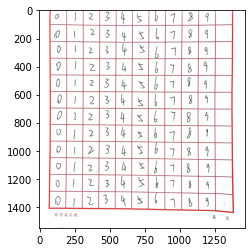

In [2]:
path = "D:/data/1.jpg"
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img, cmap="gray")

Extract channels from the image.

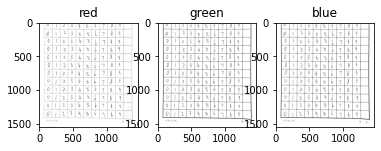

In [3]:
channels = cv2.split(img)
labels = ["red", "green", "blue"]

for i, channel in enumerate(channels):
    plt.subplot(1, 3, i+1)
    plt.imshow(channel, cmap="gray")
    plt.title(labels[i])
plt.show()

Threshold.

Text(0.5, 1.0, 'Red channel Tresh')

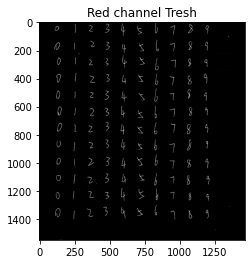

In [12]:
_, thresh = cv2.threshold(channels[0], 60, 255, cv2.THRESH_BINARY_INV)

plt.imshow(thresh, cmap="gray")
plt.title("Red channel Tresh")

Expend the thresh.

Text(0.5, 1.0, 'Red channel dilate')

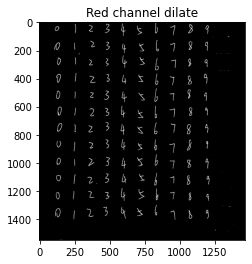

In [13]:
kernel_size = (2, 2)
kernel = np.ones(kernel_size, np.uint8)
dilate = cv2.dilate(thresh, kernel, iterations=1)

plt.imshow(dilate, cmap="gray")
plt.title("Red channel dilate")

Find Borders

In [6]:
def extract_peek(array_vals, min_vals=10, min_rect=5):
    extract_points = []
    start_point = None
    end_point = None
    for i, point in enumerate(array_vals):
        if point > min_vals and start_point == None:
            start_point = i
        elif point < min_vals and start_point != None:
            end_point = i

        if start_point != None and end_point != None:
            extract_points.append((start_point, end_point))
            start_point = None
            end_point = None

    for point in extract_points:
        if point[1] - point[0] < min_rect:
            extract_points.remove(point)
    return extract_points

def find_borders(img):
    hori_vals = np.sum(img, axis=1)
    hori_points = extract_peek(hori_vals)
    rows = []
    
    for hori_point in hori_points:
        extract_img = img[hori_point[0]:hori_point[1], :]
        vec_vals = np.sum(extract_img, axis=0)
        vec_points = extract_peek(vec_vals, min_rect=0)
        borders = []
        for vect_point in vec_points:
            border = [(vect_point[0], hori_point[0]),(vect_point[1], hori_point[1])]
            borders.append(border)
        borders.sort(key=lambda x: x[0][0])
        if len(borders) == 10:
            rows.append(borders)
    
    rows.sort(key=lambda x: x[0][0][1])
    return rows

0


Text(0.5, 1.0, 'Borders')

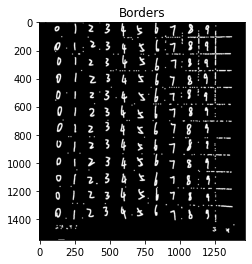

In [7]:
rows = find_borders(dilate)

print(len(rows))
result = cv2.cvtColor(dilate, cv2.COLOR_GRAY2RGB)
for row in rows:
    for border in row:
        cv2.rectangle(result, border[0], border[1], (0, 150, 200), 5)

plt.imshow(result, cmap="gray")
plt.title("Borders")

Cut the borders.

In [8]:
size = (28, 28)
img_data = np.zeros((len(rows), 10, size[0], size[0], 1), dtype='uint8')
bin = dilate

for i, row in enumerate(rows):
    for j, border in enumerate(row):
        border_img = bin[border[0][1]:border[1][1], border[0][0]:border[1][0]]
        extend_piexl = (max(border_img.shape) - min(border_img.shape)) // 2
        target_img = cv2.copyMakeBorder(border_img, 7, 7, extend_piexl + 7, extend_piexl + 7, cv2.BORDER_CONSTANT)
        target_img = cv2.resize(target_img, size)
        target_img = np.expand_dims(target_img, axis=-1)
        img_data[i, j] = target_img

Reshape the dataset.

In [9]:
img_data = img_data.reshape((-1, 28, 28, 1))
label_data = np.array(range(10))
label_data = np.tile(label_data, len(rows))

shuffle_index = np.random.permutation(img_data.shape[0])
img_data = img_data[shuffle_index]
label_data = label_data[shuffle_index]

for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(img_data[i], cmap="gray")
    plt.title(label_data[i])
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

Save the dataset.

In [20]:
np.save("image_data.npy", img_data)
np.save("label_data.npy", label_data)